Sơ bộ về dữ liệu: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_limit                9770 non-null   object 
 1   Gender                    10000 non-null  object 
 2   approv_in_adv             9940 non-null   object 
 3   loan_type                 10000 non-null  object 
 4   loan_purpose              9994 non-null   object 
 5   Credit_Worthiness         10000 non-null  object 
 6   open_credit               10000 non-null  object 
 7   business_or_commercial    10000 non-null  object 
 8   loan_amount               10000 non-null  int64  
 9   rate_of_interest          7527 non-null   float64
 10  Upfront_charges           7318 non-null   float64
 11  Neg_ammortization         9993 non-null   object 
 12  interest_only             10000 non-null  object 
 13  lump_sum_payment          10000 non-null  o

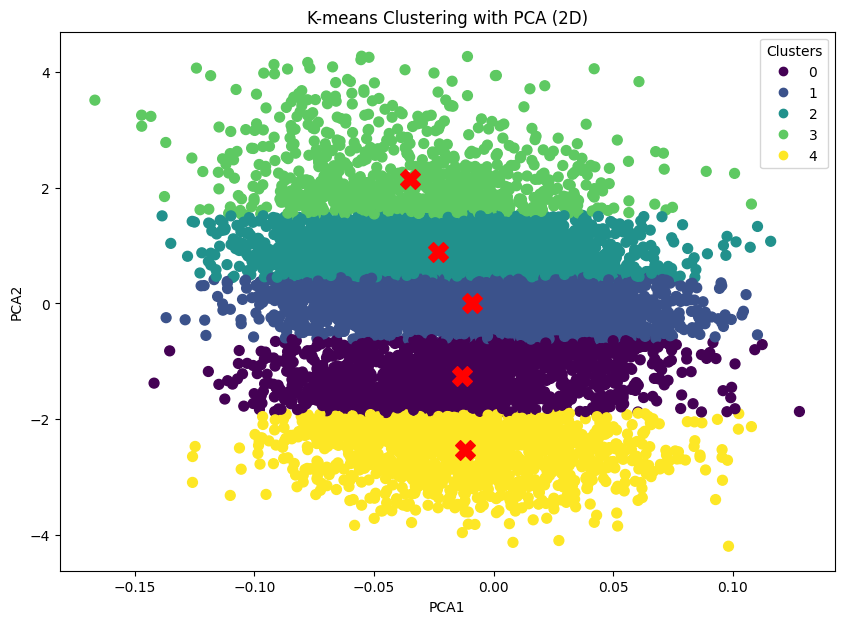

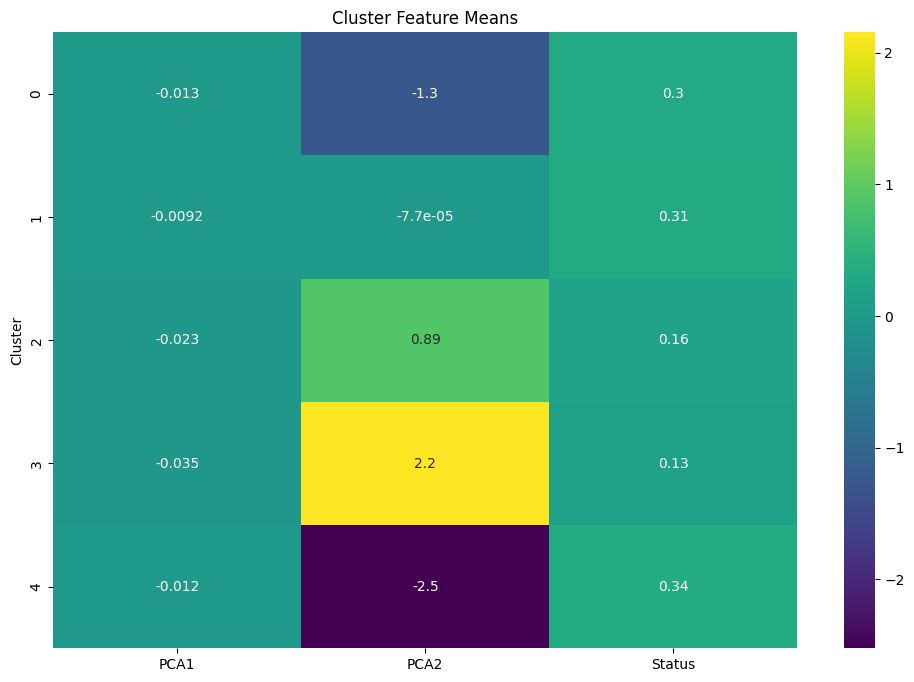

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import pairwise_distances_argmin, silhouette_score
from sklearn.decomposition import PCA
from scipy import stats

def readData():
    df = pd.read_csv('Loan_Default.csv')

    x = df.drop(['ID','year','term','Interest_rate_spread','property_value','submission_of_application'],axis=1)
    x = x[:10000]
    y = df['Status']
    y = y[:10000]
    print("Sơ bộ về dữ liệu: ")
    print(x.info())
    
    oneHotEncoder = LabelEncoder()
    for i in x.columns:
        if not pd.api.types.is_numeric_dtype(x[i]):
            x[i] = oneHotEncoder.fit_transform(x[i])
    y = oneHotEncoder.fit_transform(y)

    mean_values = df.select_dtypes(include=['number']).mean()
    x = x.fillna(mean_values)
    print("Dữ liệu sau chuẩn hóa: ")
    print(x.info())
    return x, y

# Gọi hàm và lưu trữ các giá trị trả về
x, y = readData()

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Giảm số chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

# Hiển thị tỷ lệ phương sai được giải thích bởi các thành phần PCA
print('Explained variance ratio (first two components):', pca.explained_variance_ratio_)

# Phát hiện và loại bỏ các điểm ngoại lai
z_scores = np.abs(stats.zscore(x_pca))
threshold = 3
non_outliers = (z_scores < threshold).all(axis=1)

# Lọc dữ liệu để loại bỏ các điểm ngoại lai
x_pca_cleaned = x_pca[non_outliers]
y_cleaned = y[non_outliers]

print(f"Trước khi loại bỏ: {x_pca.shape[0]} điểm dữ liệu")
print(f"Sau khi loại bỏ: {x_pca_cleaned.shape[0]} điểm dữ liệu")

def kmeans_init_centers(X, k):
    return X[np.random.choice(X.shape[0], k, replace=False)]

def kmeans_assign_labels(X, centers):
    distances = pairwise_distances_argmin(X, centers)
    return distances

def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        Xk = X[labels == k, :]
        if len(Xk) > 0:
            centers[k, :] = np.mean(Xk, axis=0)
    return centers

def has_converged(centers, new_centers):
    return np.allclose(centers, new_centers, atol=1e-6)

def kmeans(X, K, max_iters=100):
    centers = kmeans_init_centers(X, K)
    for it in range(max_iters):
        labels = kmeans_assign_labels(X, centers)
        new_centers = kmeans_update_centers(X, labels, K)
        if has_converged(centers, new_centers):
            break
        centers = new_centers
    return centers, labels

def custom_kmeans_clustering(x_pca, y, n_clusters):
    # Áp dụng K-means tự xây để phân cụm dữ liệu đã giảm chiều
    centers, labels = kmeans(x_pca, n_clusters)


    # Tạo DataFrame kết quả
    result = pd.DataFrame(x_pca, columns=['PCA1', 'PCA2'])
    result['Cluster'] = labels
    result['Status'] = y

    # Lưu kết quả phân cụm vào file CSV mới
    result.to_csv('clustered_data.csv', index=False)
    return result, centers

def analyze_clusters(df):
    cluster_summary = df.groupby('Cluster').mean()
    return cluster_summary

def plot_clusters(df, centers):
    # Biểu đồ tán xạ 2D của các cụm
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=50)

    # Vẽ các điểm đánh dấu tâm của các cụm
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')

    # Thêm màu cho các cụm
    plt.legend(*scatter.legend_elements(), title="Clusters")

    # Thiết lập tiêu đề và nhãn trục
    plt.title('K-means Clustering with PCA (2D)')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    
    plt.show()

    # Biểu đồ nhiệt cho các đặc trưng trung bình của các cụm
    cluster_summary = analyze_clusters(df)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_summary, annot=True, cmap='viridis')
    plt.title('Cluster Feature Means')
    plt.show()

# Áp dụng K-means tự xây và đánh giá kết quả với dữ liệu đã loại bỏ ngoại lai
clustered_data_cleaned, centers_cleaned = custom_kmeans_clustering(x_pca_cleaned, y_cleaned, n_clusters=5)
print(clustered_data_cleaned.head())

# Trực quan hóa kết quả
plot_clusters(clustered_data_cleaned, centers_cleaned)


In [138]:
print(clustered_data_cleaned)

          PCA1      PCA2  Cluster  Status
0     0.051959 -1.670288        0       1
1     0.029254 -2.502440        4       1
2    -0.011344 -0.458867        1       0
3    -0.062738  0.828614        2       0
4     0.031131  0.187521        1       0
...        ...       ...      ...     ...
9957 -0.044778  1.194463        2       0
9958 -0.047978 -2.813449        4       0
9959 -0.057097  0.196173        1       0
9960 -0.013364  1.069979        2       0
9961 -0.040097  0.974335        2       0

[9962 rows x 4 columns]


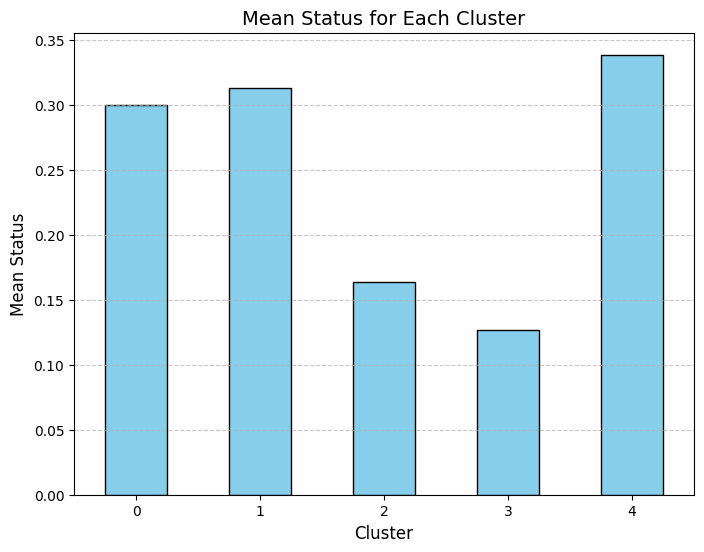

             PCA1      PCA2    Status
Cluster                              
0       -0.013236 -1.252882  0.299929
1       -0.009223 -0.000077  0.312641
2       -0.023404  0.889518  0.163608
3       -0.034780  2.155752  0.126609
4       -0.011861 -2.525377  0.338403


In [139]:
def analyze_clusters(df):
    cluster_summary = df.groupby('Cluster').mean()
    return cluster_summary

# Phân tích các cụm
# Phân tích cụm và tính giá trị trung bình của Status
cluster_summary = analyze_clusters(clustered_data_cleaned)

# Lấy giá trị trung bình của Status cho từng cụm
status_means = cluster_summary['Status']

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
status_means.plot(kind='bar', color='skyblue', edgecolor='black')

# Thêm tiêu đề và nhãn
plt.title('Mean Status for Each Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Mean Status', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(cluster_summary)


In [140]:
# Giảm số chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

# Hiển thị tỷ lệ phương sai được giải thích bởi các thành phần PCA
print('Explained variance ratio (first two components):', pca.explained_variance_ratio_)

# Lấy các hệ số PCA
pca_components = pca.components_
print('PCA Components:')
print(pd.DataFrame(pca_components, columns=x.columns, index=['PCA1', 'PCA2']))


Explained variance ratio (first two components): [0.10724503 0.07352033]
PCA Components:
      loan_limit    Gender  approv_in_adv  loan_type  loan_purpose  \
PCA1   -0.002571 -0.007056      -0.002072  -0.004101     -0.016375   
PCA2    0.053301 -0.031120      -0.059941  -0.454336      0.147837   

      Credit_Worthiness  open_credit  business_or_commercial  loan_amount  \
PCA1          -0.001184    -0.001176                0.001789    -0.008613   
PCA2           0.011633     0.089830                0.462558     0.281719   

      rate_of_interest  ...    income  credit_type  Credit_Score  \
PCA1          0.001737  ... -0.002393    -0.001491      0.010645   
PCA2          0.044648  ...  0.356907    -0.041503      0.002210   

      co-applicant_credit_type       age       LTV    Region  Security_Type  \
PCA1                  0.008740 -0.013874  0.011151 -0.010538      -0.576918   
PCA2                  0.092059  0.027523 -0.399975  0.015696      -0.002961   

        Status     dtir1 

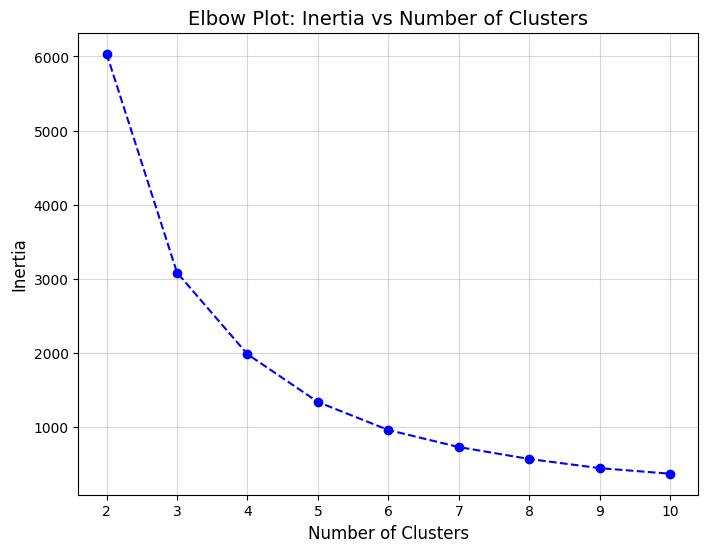

In [141]:
def elbow_plot_inertia(x_pca_cleaned, y_cleaned, max_clusters=10):
    """
    Vẽ biểu đồ khuỷu dựa trên tổng bình phương khoảng cách (inertia) giữa các điểm và tâm cụm.
    """
    inertia_values = []

    # Tính inertia cho từng số cụm từ 2 đến max_clusters
    for n_clusters in range(2, max_clusters + 1):
        clustered_data, centers = custom_kmeans_clustering(x_pca_cleaned, y_cleaned, n_clusters)

        # Tính tổng bình phương khoảng cách (inertia)
        inertia = 0
        for i in range(n_clusters):
            cluster_points = clustered_data[clustered_data['Cluster'] == i][['PCA1', 'PCA2']]
            cluster_center = centers[i]
            inertia += np.sum(np.linalg.norm(cluster_points.values - cluster_center, axis=1) ** 2)
        inertia_values.append(inertia)

    # Vẽ biểu đồ khuỷu
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), inertia_values, marker='o', linestyle='--', color='blue')
    plt.title('Elbow Plot: Inertia vs Number of Clusters', fontsize=14)
    plt.xlabel('Number of Clusters', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.xticks(range(2, max_clusters + 1))
    plt.grid(alpha=0.5)
    plt.show()

# Vẽ biểu đồ khuỷu
elbow_plot_inertia(x_pca_cleaned, y_cleaned, max_clusters=10)
